In [1]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator
import keras_video.utils
import tensorflow
from tensorflow.keras import backend
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import (Conv2D, MaxPooling3D, Conv3D,MaxPooling2D)
from tensorflow.keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from collections import deque
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import os.path
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Loading the Saved Model & Weights

In [2]:
# Set the path to the saved location of the JSON file containing model architecture . 

with open('F:/DLProj/1_2_Sub/v1/v1.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model = tensorflow.keras.models.model_from_json(json_savedModel)

# Load the saved model weight file
model.load_weights('F:/DLProj/1_2_Sub/v1/Weights/model_saved.68-1.07.hdf5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_84 (TimeDis (None, 15, 98, 98, 32)    4736      
_________________________________________________________________
time_distributed_85 (TimeDis (None, 15, 96, 96, 32)    9248      
_________________________________________________________________
time_distributed_86 (TimeDis (None, 15, 96, 96, 32)    128       
_________________________________________________________________
time_distributed_87 (TimeDis (None, 15, 96, 96, 32)    0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, 15, 48, 48, 32)    0         
_________________________________________________________________
time_distributed_89 (TimeDis (None, 15, 48, 48, 64)    18496     
_________________________________________________________________
time_distributed_90 (TimeDis (None, 15, 48, 48, 64)   

In [3]:
optimizer= RMSprop(lr=1e-4)
model.compile(optimizer=optimizer , 
              loss='categorical_crossentropy',
              #loss='binary_crossentropy',
              metrics=['accuracy'])

# Testing the model on new data

In [4]:
import numpy as np
img_rows, img_cols, img_depth = 300, 300, 15

In [5]:
def predict_door(input_file, output_file, image_path):
    x_train = [] #Variable for storing the files 
    ## Code for extracting 15 frames (distanced at equal interval in the video) from Door Training set
    t_hold = 0.501 #threshold for class prediction
    vid_p = input_file
    interval_duration = 7 # This defines the seconds after which we make a prediction
    frames = []
    legend = []
    cap = cv2.VideoCapture(vid_p)
    fps = cap.get(5) # Getting the frames per second. 
    total_frames = int(cap.get(7))  #Total frames in the video
    vid_dur = int(total_frames/fps) # Gives the video duration in seconds
    intervals = int(vid_dur/interval_duration) #This defines how many predictions we'll make
    if intervals == 0:
        intervals = 1
    frame_per_interval = total_frames //intervals #This defines how many frames are in total for each prediction duration (7 secs)
    frame_distance = frame_per_interval//img_depth #This defines the no. of frames we'll skip.

    frame_count = 0 # This variable keeps count of the total frames, and is reset after extracting each frame
    save_frame = 0 
    interval_count = 1
    
    # Parameters for the plot.
    fig = plt.figure(figsize = (10,10), dpi = 200)
    plt.xlabel("Time (secs)")
    plt.ylabel("label")
    
    for i in range (total_frames): #iterating over all the frames of the video.
            ret, frame = cap.read()
            if ret ==False:  # Checking if the frame is missing, and if missing, we take the previous frame
                frame = f_prev
            elif ret==True:
                f_prev =frame
            frame_count +=1
            if frame_count ==(frame_distance):
                frame_count = 0
                frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                frames.append(frame)

            if i == ((interval_count*frame_per_interval)-1):
                inpt = np.array(frames)
                inpt = inpt.astype('float32')
                inpt -= np.mean(inpt)
                inpt /=np.max(inpt)
                
                frames = []
                mod_in = np.zeros((1, 15, 300, 300, 3))
                mod_in[0][:][:][:][:] = inpt[:15][:][:][:]
                p = model.predict(mod_in, batch_size = 1)#verbose = 1)
                prob = p[:][0][0]
                s0 = (interval_count-1)*interval_duration #Starting time of the interval in secs
                s1 = (interval_count)*interval_duration   # Ending time of the interval in secs
                print(p)
                if prob >= t_hold:
                    s2 = [('Door: ' +  str(s0) + 'secs - ' + str(s1) + 'secs.')]
                    s3 = 'door'
                    s4 = [s3,s3,s3,s3,s3,s3,s3]
                else:
                    s2 = [('Not_Door: ' +  str(s0) + 'secs - ' + str(s1) + 'secs.')]
                    s3 = 'Not Door'
                    s4 = [s3,s3,s3,s3,s3,s3,s3]
                plot_interval = range((interval_count-1)*7 , (interval_count*7))
                plt.plot(plot_interval, s4, 'o', linestyle='--', color = 'blue')  
                plt.fill_between(plot_interval,(s3), color = 'gray')
                
                print(interval_count)
                interval_count += 1 #Incrementing interval count by 1
                print(s3)
                legend.append(s2)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()
    print(legend)
    with open(output_file, 'w') as f:
        f.write(str(legend))
    plot_title= 'Predicted Labels for Video File'
    plt.title(plot_title)
    plt.savefig(image_path)

[[0.7908334  0.20916659]]
1
door
[[0.35216624 0.64783376]]
2
Not Door
[['Door: 0secs - 7secs.'], ['Not_Door: 7secs - 14secs.']]


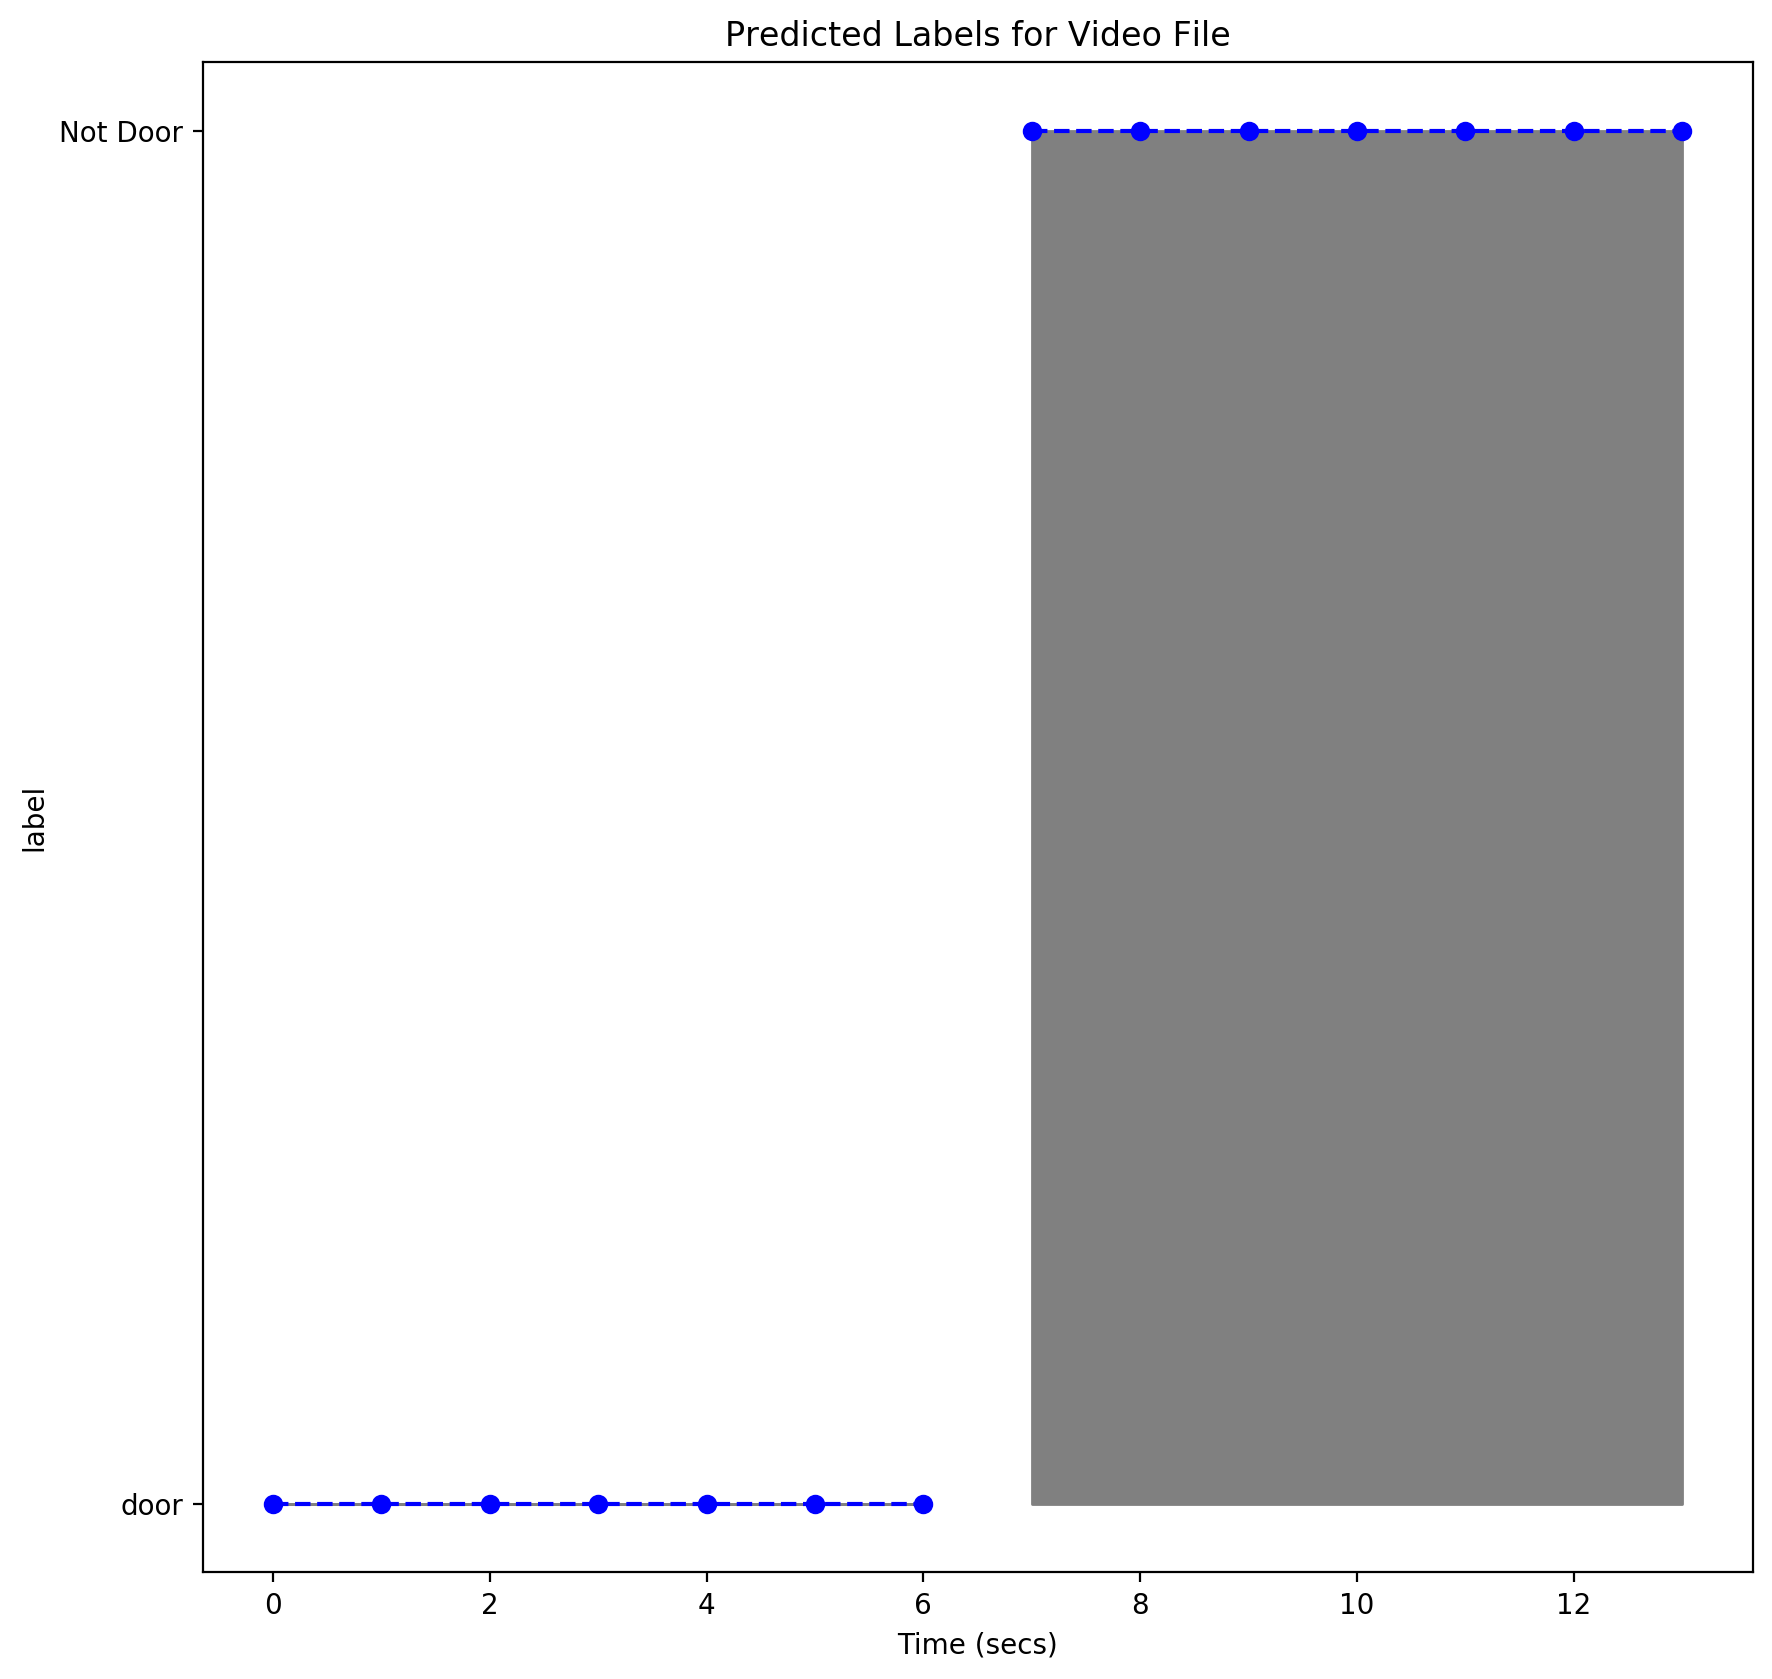

In [7]:
in_1 = 'F:/Testing/00T4B.MP4' # Input the path of the video
out_2 = 'F:/Testing/00T4B.json' #Input the path of the JSON File 
img_path = 'F:/Testing/00T4B.jpeg'
predict_door(in_1 , out_2, img_path)